In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')
import importlib

from __init__ import *
from __init__jupyterlab import *
import matplotlib.ticker as ticker


import collections
from collections import deque
from scipy import stats
from scipy import optimize 
from scipy.optimize import curve_fit

import queue
# import tables
from scipy import sparse
from sklearn.model_selection import KFold
# from sklearn.decomposition import PCA
# from sklearn.neighbors import NearestNeighbors
# from sklearn.utils.sparsefuncs import mean_variance_axis
import fbpca
from statsmodels.stats.multitest import multipletests
import datetime


import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_clst_utils
importlib.reload(CEMBA_clst_utils)
import cluster_cv_utils
import CEMBA_preproc_utils

# from CEMBA_run_tsne import run_tsne
# from CEMBA_run_tsne import run_tsne_v2

## Basic settings 
- use ```mods``` and ```settings[mod]``` to access modality specific information

In [2]:
name = "downsample_reads_cells_{}".format(datetime.datetime.now().date())
mods_selected = [
#     'snmcseq_gene',
#     'snatac_gene',
    'smarter_cells',
    'smarter_nuclei',
#     '10x_cells_v2', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
    ]

SRC_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'
DST_DIR = '/cndd2/fangming/projects/miniatlas'
output_figures = '/cndd2/fangming/projects/miniatlas/results/figures/{}_{{}}.pdf'.format(name)
output_figures

'/cndd2/fangming/projects/miniatlas/results/figures/downsample_reads_cells_2020-05-14_{}.pdf'

In [3]:
# # gene id (abbr) as index
gene_annot_file = PATH_GENEBODY_ANNOTATION
gene_annot = pd.read_csv(gene_annot_file, sep="\t")
gene_annot['gene_id_abbr'] = gene_annot['gene_id'].apply(lambda x: x.split('.')[0])
gene_annot = gene_annot.set_index('gene_id_abbr')

gene_lengths_base = (gene_annot['end'] - gene_annot['start'])
print(gene_lengths_base.head())

gene_id_abbr
ENSMUSG00000102693      1069
ENSMUSG00000064842       109
ENSMUSG00000051951    465597
ENSMUSG00000102851       479
ENSMUSG00000103377      2818
dtype: int64


In [6]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *


f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [7]:
# back compatible
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'
f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

In [8]:
# downsample_cells = [1000, 2000, 4000, 5911]
# downsample_reads = np.array([1e4, 3e4, 5e4, 1e5, 3e5, 5e5, 0.98*1e6])

# downsample_cells = [2000, 4000, 5911]
# downsample_reads = np.array([1e4, 3e4, 5e4, 1e5, 3e5, 5e5,])

In [9]:
normalization_options = {
    'smarter_nuclei': 'TPM',
    'smarter_cells': 'TPM',
    '10x_nuclei_v3_macosko': 'CPM',
    '10x_cells_v3': 'CPM',
    '10x_nuclei_v3': 'CPM',
    '10x_cells_v2': 'CPM',
}

In [10]:
f_format = 'clst_neuron_downsamp_mod-*_ncell-*_nread-*_r-*_i-*_*.tsv'

summary = []

with snmcseq_utils.cd('/cndd2/fangming/projects/miniatlas/results'):
    files = np.sort(glob.glob(f_format))
    
    for i, file in enumerate(files):
        if i % 100 == 0:
            print("{}".format(i))
        _, mod, ncell, nread, r, i_repeat = file.split('-')
        mod = mod[:-len('_ncell')]
        ncell = ncell[:-len('_nread')]
        nread = nread[:-len('_r')] 
        r = r[:-len('_i')]
        i_repeat = i_repeat[:-len('_200512.tsv')]
        
        _df = pd.read_csv(file, sep='\t')
        nclst = len(_df['cluster'].unique())
        summary.append({
            'mod': mod, 
            'ncell': int(ncell), 
            'nread': int(float(nread)),
            'r': r,
            'i_repeat': int(i_repeat),
            'nclst': int(nclst),
        })
        
        
summary = pd.DataFrame(summary) 
                               
print(summary.shape)
summary.head()
        
        


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
(2296, 6)


,i_repeat,mod,ncell,nclst,nread,r
0,0,10x_cells_v2,10000,59,1000,6
1,1,10x_cells_v2,10000,59,1000,6
2,2,10x_cells_v2,10000,54,1000,6
3,3,10x_cells_v2,10000,59,1000,6
4,4,10x_cells_v2,10000,61,1000,6


In [11]:
# # read in matrix

# metas = collections.OrderedDict()
# gxc_raws = collections.OrderedDict()
# num_reads_all = collections.OrderedDict()


# for mod in mods_selected:
#     ti = time.time()
#     print(mod)
    
#     ## read data
#     # read metadata
#     normalization_option = normalization_options[mod]
#     f_meta = f_meta_format.format(SRC_DIR, mod) ##
#     meta = pd.read_csv(f_meta, sep="\t", index_col=0)
#     metas[mod] = meta
        
#     f_data = f_data_format.format(SRC_DIR, mod, '', 'npz') 
#     f_data_gene = f_data_format.format(SRC_DIR, mod, '', 'gene') 
#     f_data_cell = f_data_format.format(SRC_DIR, mod, '', 'cell') 
    
#     # read counts matrix 
#     print(mod, "Reading in files {}".format(time.time()-ti))
#     gxc_raw = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
#     gxc_raws[mod] = gxc_raw
    
#     num_cells = len(meta)
#     num_reads = gxc_raw.data.sum().sum()/num_cells
#     num_reads_all[mod] = num_reads
    
#     print(gxc_raw.data.shape, num_cells, num_reads)
    
#     # check meta cells agree with gxc cells
#     assert np.all(meta.index.values == gxc_raw.cell)
#     # check genes are uniq 
#     assert len(gxc_raw.gene) == len(np.unique(gxc_raw.gene)) 
    
#     print(mod, "Total time used: {}".format(time.time()-ti))

In [12]:
# get n clusters

### Making plots

In [13]:
print(summary.shape)
summary.head()

(2296, 6)


,i_repeat,mod,ncell,nclst,nread,r
0,0,10x_cells_v2,10000,59,1000,6
1,1,10x_cells_v2,10000,59,1000,6
2,2,10x_cells_v2,10000,54,1000,6
3,3,10x_cells_v2,10000,59,1000,6
4,4,10x_cells_v2,10000,61,1000,6


In [14]:
summary['ncell'].unique()
summary.loc[summary['mod']=='smarter_nuclei', 'ncell'].unique()

array([1000, 2000, 4000, 5911])

In [15]:
def plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=[], logscale=False):
    """
    """
    for mod in mods_plot:
        conds = (
                (summary['mod']==mod) 
                & (summary['ncell']==ncell)
                & (summary['r']==r)
                )
        if nread_range:
            conds = (conds & (summary['nread'].isin(nread_range)))
        color = settings[mod].color
        _mean_curve = summary[conds].groupby('nread').agg({'nclst': np.mean}).reset_index()
        _err_curve = summary[conds].groupby('nread').agg({'nclst': np.std}).reset_index()
        ax.plot(_mean_curve['nread'].values, _mean_curve['nclst'].values, '-o', color=color, label=settings[mod].name)
        n_repeats = summary[conds]['i_repeat'].max()+1
        ax.fill_between(_mean_curve['nread'].values, 
                        _mean_curve['nclst'].values - (1.96/np.sqrt(n_repeats))*_err_curve['nclst'].values, 
                        _mean_curve['nclst'].values + (1.96/np.sqrt(n_repeats))*_err_curve['nclst'].values, 
                        color=color, alpha=0.5,
                       )
        ax.set_title("ncell{}_r{}_nrep{}".format(ncell, r, n_repeats))
        ax.set_xlabel('num. reads')
        if logscale:
            ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set_ylabel('num. clusters')
        
    return ax


In [16]:
def plot_ncell_vs_nclst(ax, summary, mods_plot, nread, r, ncell_range=[], logscale=False):
    """
    """
    for mod in mods_plot:
        conds = (
                (summary['mod']==mod) 
                & (summary['nread']==nread)
                & (summary['r']==r)
                )
        if ncell_range:
            conds = (conds & (summary['ncell'].isin(ncell_range)))
        color = settings[mod].color
        _mean_curve = summary[conds].groupby('ncell').agg({'nclst': np.mean}).reset_index()
        _err_curve = summary[conds].groupby('ncell').agg({'nclst': np.std}).reset_index()
        ax.plot(_mean_curve['ncell'].values, _mean_curve['nclst'].values, '-o', color=color, label=settings[mod].name)
        n_repeats = summary[conds]['i_repeat'].max()+1
        ax.fill_between(_mean_curve['ncell'].values, 
                        _mean_curve['nclst'].values - (1.96/np.sqrt(n_repeats))*_err_curve['nclst'].values, 
                        _mean_curve['nclst'].values + (1.96/np.sqrt(n_repeats))*_err_curve['nclst'].values, 
                        color=color, alpha=0.5,
                       )
        ax.set_title("nread{}_r{}_nrep{}".format(nread, r, n_repeats))
        ax.set_xlabel('num. cells')
        if logscale:
            ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set_ylabel('num. clusters')
        
    return ax


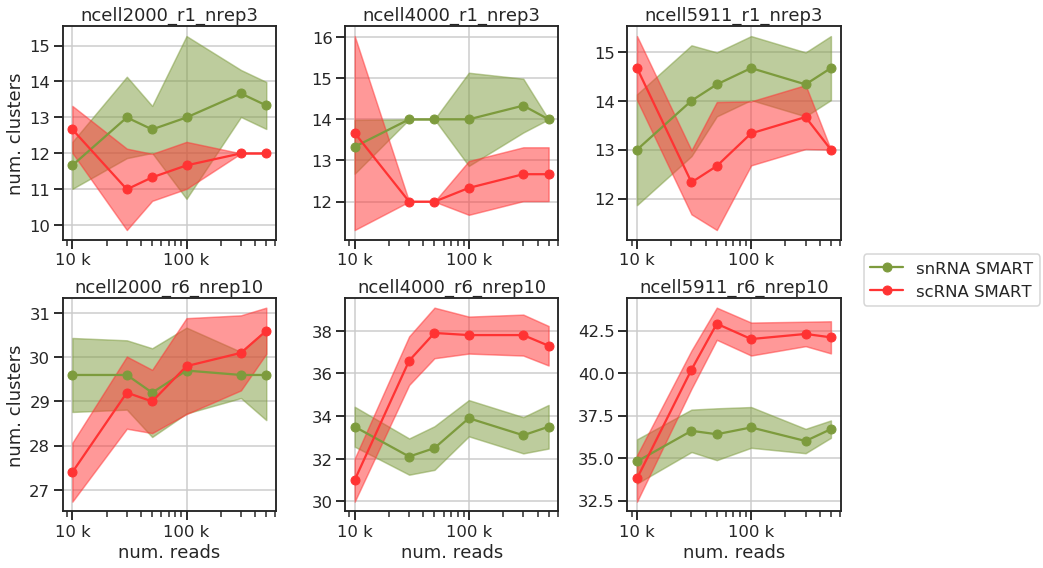

In [17]:
ncells = [
    2000, 4000, 5911, 
]
rs = ['1', '6']

mods_plot = [
    'smarter_nuclei',
    'smarter_cells',
]

nx = len(ncells)
ny = len(rs)
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
for i, r in enumerate(rs):
    for j, ncell in enumerate(ncells):
        ax = axs[i,j]
        plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, logscale=True)
            
        if j > 0:
            ax.set_ylabel('')
        if i < ny-1:
            ax.set_xlabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      

fig.tight_layout()
output = output_figures.format('1_smartseq')
snmcseq_utils.savefig(fig, output)
plt.show()

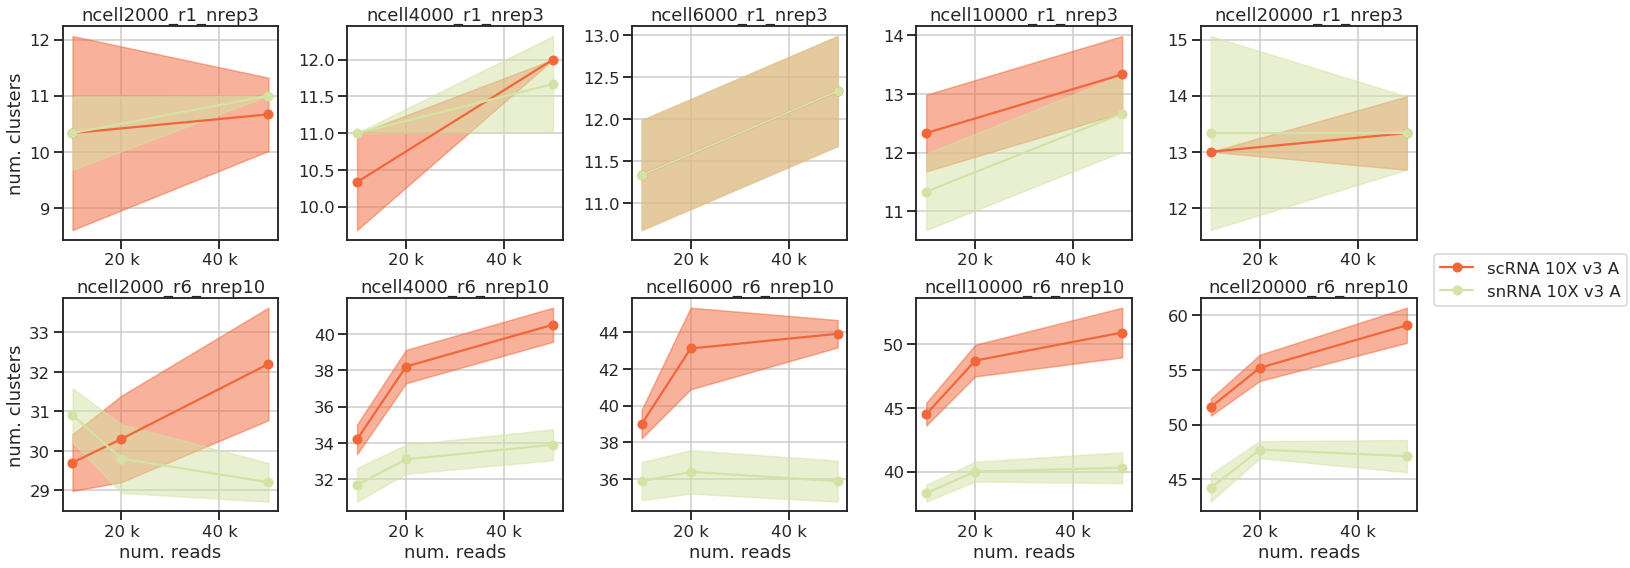

In [19]:
ncells = [
    2000, 4000, 6000, 10000, 20000, 
]
rs = ['1', '6']

mods_plot = [
    '10x_cells_v3',
    '10x_nuclei_v3',
]
n_repeats = 3
nread_range = [10000, 20000, 50000]


nx = len(ncells)
ny = len(rs)
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))

for i, r in enumerate(rs):
    for j, ncell in enumerate(ncells):
        ax = axs[i,j]
        plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=False)
        if j > 0:
            ax.set_ylabel('')
        if i < ny-1:
            ax.set_xlabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('2_10x_v3')
snmcseq_utils.savefig(fig, output)
plt.show()

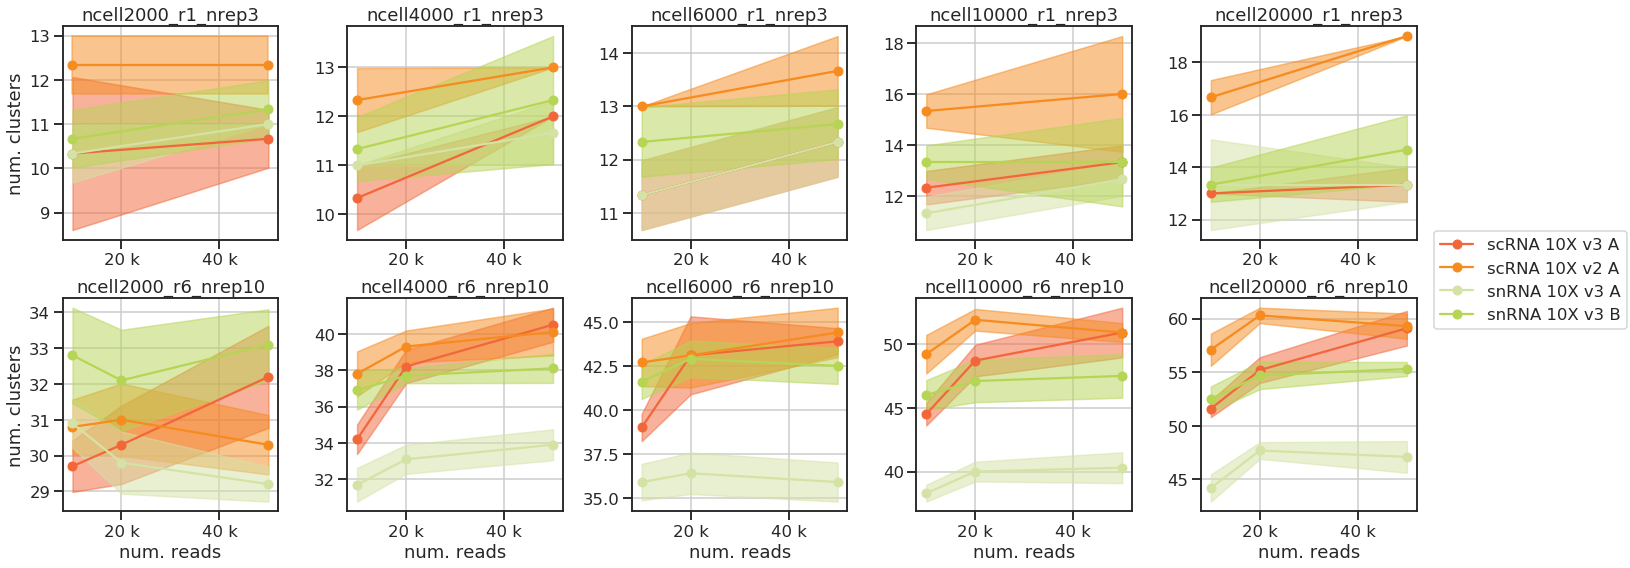

In [20]:
ncells = [
    2000, 4000, 6000, 10000, 20000, 
]
rs = ['1', '6']

mods_plot = [
    '10x_cells_v3',
    '10x_cells_v2',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
]
n_repeats = 3
nread_range = [10000, 20000, 50000]


nx = len(ncells)
ny = len(rs)
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))

for i, r in enumerate(rs):
    for j, ncell in enumerate(ncells):
        ax = axs[i,j]
        plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=False)
        if j > 0:
            ax.set_ylabel('')
        if i < ny-1:
            ax.set_xlabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('3_all_10x')
snmcseq_utils.savefig(fig, output)
plt.show()

In [21]:
# # everyting combined

# ncells = [
#     2000, 4000, 6000, 10000, 20000, 
# ]
# rs = ['1', '6']

# nread_range = [10000, 20000, 50000]
# mods_plot = [
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     'smarter_nuclei',
#     'smarter_cells',
# ]
# n_repeats = 3


# nx = len(ncells)
# ny = len(rs)
# fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))

# for i, r in enumerate(rs):
#     for j, ncell in enumerate(ncells):
#         ax = axs[i,j]
#         plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=False)
#         if j > 0:
#             ax.set_ylabel('')
#         if i < ny-1:
#             ax.set_xlabel('')
            
        
# fig.tight_layout()
# plt.show()

### Making plots round2

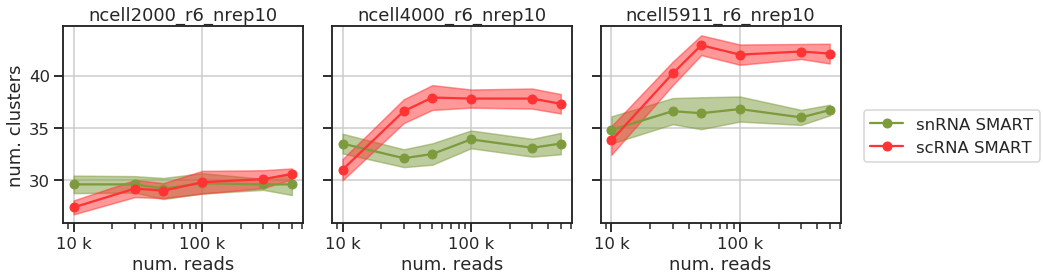

In [23]:
ncells = [
    2000, 4000, 5911, 
]
r = '6'
mods_plot = [
    'smarter_nuclei',
    'smarter_cells',
]

n_repeats = 3
nread_range = []


nx = len(ncells)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, ncell in enumerate(ncells):
    ax = axs[j]
    plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=True)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r2-1-2_all_smart')
snmcseq_utils.savefig(fig, output)
plt.show()

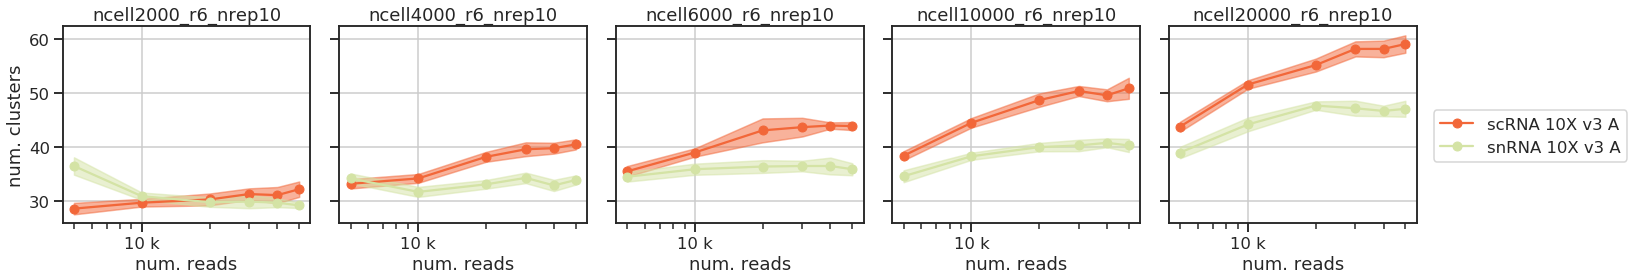

In [31]:
ncells = [
    2000, 4000, 6000, 10000, 20000, 
]
r = '6'

mods_plot = [
    '10x_cells_v3',
#     '10x_cells_v2',
    '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
]
n_repeats = 3
nread_range = [5000, 10000, 20000, 30000, 40000, 50000]


nx = len(ncells)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharey=True)

for j, ncell in enumerate(ncells):
    ax = axs[j]
    plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=True)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r2-2-2_10x_v3')
snmcseq_utils.savefig(fig, output)
plt.show()

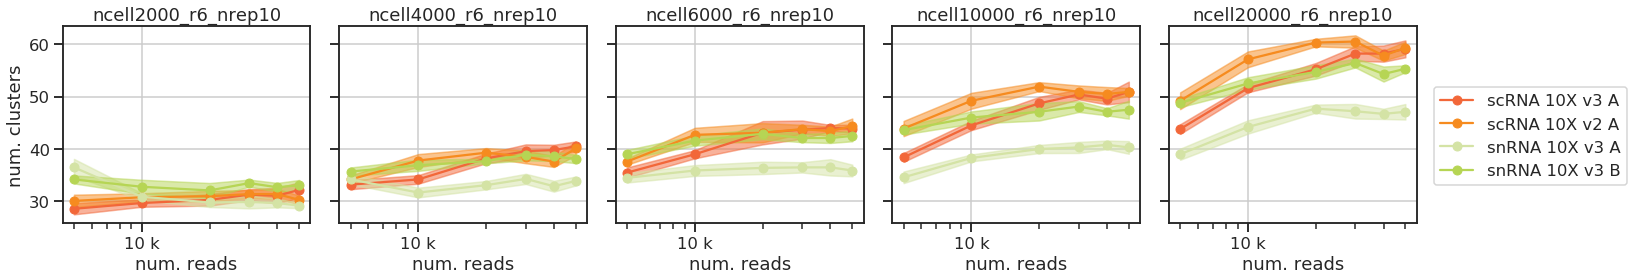

In [33]:
ncells = [
    2000, 4000, 6000, 10000, 20000, 
]
r = '6'

mods_plot = [
    '10x_cells_v3',
    '10x_cells_v2',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
]
n_repeats = 3
nread_range = [5000, 10000, 20000, 30000, 40000, 50000]


nx = len(ncells)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, ncell in enumerate(ncells):
    ax = axs[j]
    plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=True)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r2-3-2_all_10x')
snmcseq_utils.savefig(fig, output)
plt.show()

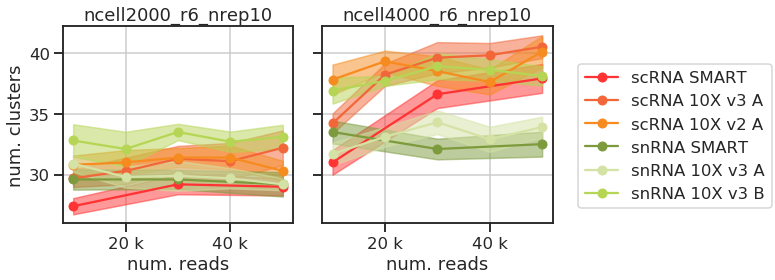

In [27]:
ncells = [
    2000, 4000, 
#     6000, 10000, 20000, 
]
r = '6'

mods_plot = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2',
    'smarter_nuclei',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
]
n_repeats = 3
nread_range = [10000, 20000, 30000, 40000, 50000]


nx = len(ncells)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, ncell in enumerate(ncells):
    ax = axs[j]
    plot_nread_vs_nclst(ax, summary, mods_plot, ncell, r, nread_range=nread_range, logscale=False)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r2-4-2_all')
snmcseq_utils.savefig(fig, output)
plt.show()

### Making plots round3

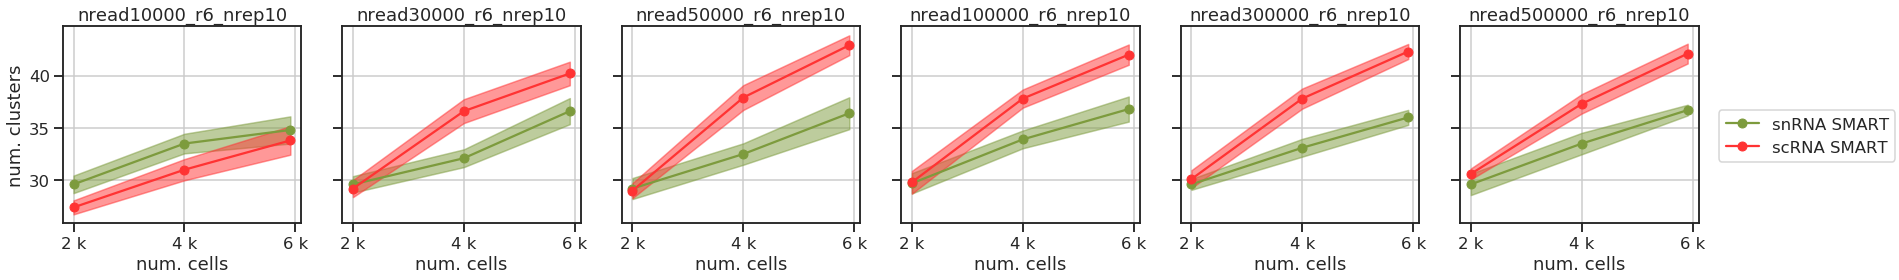

In [28]:
r = '6'

mods_plot = [
    'smarter_nuclei',
    'smarter_cells',
]

n_repeats = 3
nreads = [10000, 30000, 50000, 100000, 300000, 500000]
ncell_range = [
    2000, 4000, 5911, 
]

n_repeats = 3
nread_range = []

nx = len(nreads)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, nread in enumerate(nreads):
    ax = axs[j]
    plot_ncell_vs_nclst(ax, summary, mods_plot, nread, r, ncell_range=ncell_range, logscale=False)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r3-1_smart_all')
snmcseq_utils.savefig(fig, output)
plt.show()

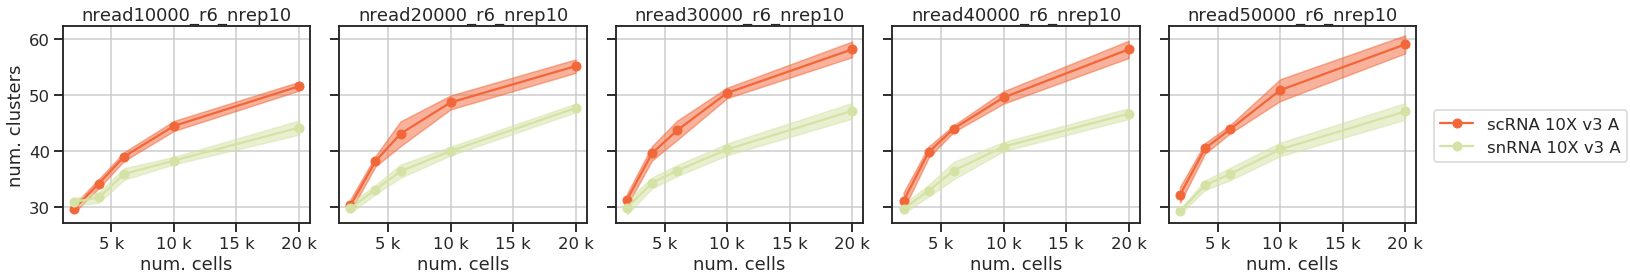

In [29]:
r = '6'

mods_plot = [
    '10x_cells_v3',
#     '10x_cells_v2',
    '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
]
n_repeats = 3
nreads = [10000, 20000, 30000, 40000, 50000]
ncell_range = [
    2000, 4000, 6000, 10000, 20000, 
]

nx = len(nreads)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, nread in enumerate(nreads):
    ax = axs[j]
    plot_ncell_vs_nclst(ax, summary, mods_plot, nread, r, ncell_range=ncell_range, logscale=False)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r3-2_10x_v3')
snmcseq_utils.savefig(fig, output)
plt.show()

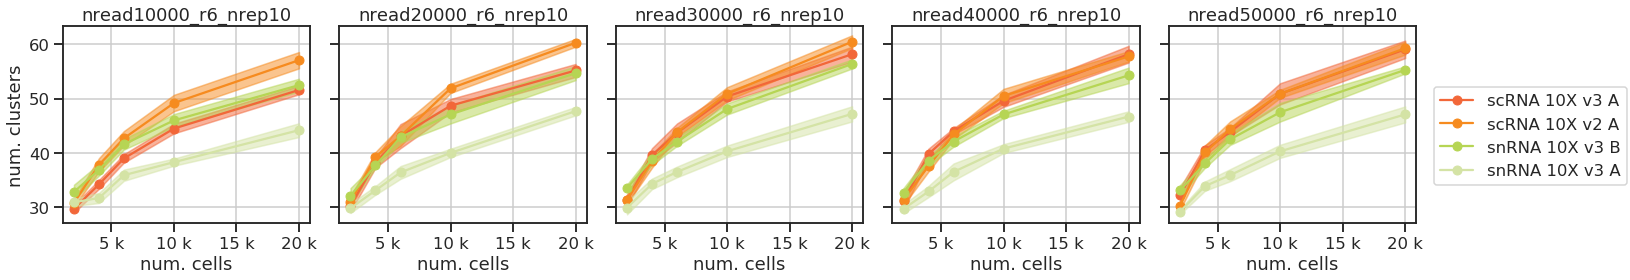

In [30]:
r = '6'

mods_plot = [
    '10x_cells_v3',
    '10x_cells_v2',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
]
n_repeats = 3
nreads = [10000, 20000, 30000, 40000, 50000]
ncell_range = [
    2000, 4000, 6000, 10000, 20000, 
]

nx = len(nreads)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, nread in enumerate(nreads):
    ax = axs[j]
    plot_ncell_vs_nclst(ax, summary, mods_plot, nread, r, ncell_range=ncell_range, logscale=False)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r3-3_10x_v3_all')
snmcseq_utils.savefig(fig, output)
plt.show()

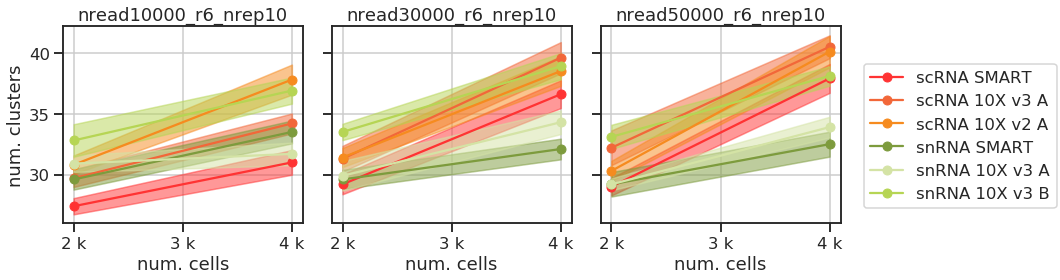

In [31]:
r = '6'

mods_plot = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2',
    'smarter_nuclei',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
]
n_repeats = 3
nreads = [10000, 30000, 50000]
ncell_range = [
    2000, 4000, 
]

nx = len(nreads)
ny = 1
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny), sharex=True, sharey=True)

for j, nread in enumerate(nreads):
    ax = axs[j]
    plot_ncell_vs_nclst(ax, summary, mods_plot, nread, r, ncell_range=ncell_range, logscale=False)
    if j > 0:
        ax.set_ylabel('')
            
# figure level legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.99,0.5))      
        
fig.tight_layout()
output = output_figures.format('r3-4_all')
snmcseq_utils.savefig(fig, output)
plt.show()